In [2]:
import numpy as np
import pandas as pd
import io
import os
import tensorflow as tf
from PIL import Image
from glob import glob
import itertools
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def prepare_for_train_test(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

    print(model.summary())
    return model;

In [ ]:
def train_model(model, X_train, Y_train, EPOCHS=25, save_path="model_weightsk.h5"):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size=64,
                        epochs=EPOCHS,
                        callbacks=[reduce_lr, early_stop])

    model.save_weights(save_path)

    return history

In [ ]:
def test_model(model, X_train, Y_train, X_test, Y_test, label_mapping):
    test_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(test_acc * 100))
    
    train_acc = model.evaluate(X_train, Y_train, verbose=0)[1]
    print("Train Accuracy: {:.3f}%".format(train_acc * 100))

    y_true_test = np.array(Y_test)
    y_pred_probs_test = model.predict(X_test)
    y_pred_test = np.array(list(map(lambda x: np.argmax(x), y_pred_probs_test)))

    precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_true_test, y_pred_test, average='weighted')
    
    print("\nTest Metrics:")
    print("Accuracy: {:.3f}".format(test_acc))
    print("Precision: {:.3f}".format(precision_test))
    print("Recall: {:.3f}".format(recall_test))
    print("F1 Score: {:.3f}".format(f1_test))

    y_true_train = np.array(Y_train)
    y_pred_probs_train = model.predict(X_train)
    y_pred_train = np.array(list(map(lambda x: np.argmax(x), y_pred_probs_train)))

    precision_train = precision_score(y_true_train, y_pred_train, average='weighted')
    recall_train = recall_score(y_true_train, y_pred_train, average='weighted')
    f1_train = f1_score(y_true_train, y_pred_train, average='weighted')
    
    print("\nTrain Metrics:")
    print("Accuracy: {:.3f}".format(train_acc))
    print("Precision: {:.3f}".format(precision_train))
    print("Recall: {:.3f}".format(recall_train))
    print("F1 Score: {:.3f}".format(f1_train))
    
    for i in range(len(X_test)):
        image_name = data['image_id'].iloc[i]
        true_label = label_mapping[y_true_test[i][0]]
        pred_label = label_mapping[y_pred_test[i]]
        confidence = y_pred_probs_test[i][y_pred_test[i]]

        print(f"Image: {image_name}, True Label: {true_label}, Predicted Label: {pred_label}, Confidence: {confidence:.4f}")
        
    clr_test = classification_report(y_true_test, y_pred_test, target_names=label_mapping.values())
    print("\nTest Classification Report:")
    print(clr_test)

    cm_test = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    sample_data_test = X_test[:15]
    plt.figure(figsize=(22, 12))

    for i in range(15):
        image_name = data['image_id'].iloc[i]
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data_test[i])
        true_label_test = label_mapping[y_true_test[i][0]]
        pred_label_test = label_mapping[y_pred_test[i]]
        confidence_test = np.max(model.predict(np.expand_dims(sample_data_test[i], axis=0)))
        plt.title(f"{true_label_test} | {pred_label_test}\nConfidence: {confidence_test:.2f}")
        plt.axis("off")
        print(f"Confidence: {confidence_test:.2f}")
    plt.show()
    
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)

    fig.update_xaxes(title_text='Epochs', row=1, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    fig.update_xaxes(title_text='Epochs', row=1, col=2)
    fig.update_yaxes(title_text='Loss', row=1, col=2)

    fig.show()

<ipython-input-3-caedcbc03918>:236: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(10015, 28, 28, 3)
(10015, 1)
(45756, 28, 28, 3)
(45756, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 64)          18496     
                                                            

Test Accuracy: 97.004%
Train Accuracy: 99.497%
63/63 [==============================] - 0s 4ms/step

Test Metrics:
Accuracy: 0.970
Precision: 0.973
Recall: 0.970
F1 Score: 0.971
1144/1144 [==============================] - 6s 5ms/step

Train Metrics:
Accuracy: 0.995
Precision: 0.995
Recall: 0.995
F1 Score: 0.995
Image: ISIC_0030309, True Label: nv, Predicted Label: nv, Confidence: 1.0000
Image: ISIC_0026191, True Label: nv, Predicted Label: nv, Confidence: 0.8720
Image: ISIC_0027032, True Label: bkl, Predicted Label: bkl, Confidence: 0.9923
Image: ISIC_0027191, True Label: nv, Predicted Label: nv, Confidence: 0.9107
Image: ISIC_0028667, True Label: nv, Predicted Label: nv, Confidence: 1.0000
Image: ISIC_0030480, True Label: nv, Predicted Label: nv, Confidence: 0.8977
Image: ISIC_0031525, True Label: nv, Predicted Label: nv, Confidence: 0.9971
Image: ISIC_0031030, True Label: mel, Predicted Label: mel, Confidence: 0.9988
Image: ISIC_0031471, True Label: nv, Predicted Label: nv, Confiden

Image: ISIC_0026799, True Label: mel, Predicted Label: mel, Confidence: 0.9860
Image: ISIC_0025055, True Label: nv, Predicted Label: nv, Confidence: 0.9998
Image: ISIC_0027177, True Label: nv, Predicted Label: nv, Confidence: 1.0000
Image: ISIC_0027341, True Label: nv, Predicted Label: nv, Confidence: 0.9992
Image: ISIC_0032289, True Label: bkl, Predicted Label: bkl, Confidence: 0.9153
Image: ISIC_0028530, True Label: bkl, Predicted Label: bkl, Confidence: 0.9997
Image: ISIC_0030934, True Label: nv, Predicted Label: nv, Confidence: 1.0000
Image: ISIC_0028267, True Label: nv, Predicted Label: nv, Confidence: 1.0000
Image: ISIC_0031072, True Label: df, Predicted Label: df, Confidence: 1.0000
Image: ISIC_0028037, True Label: nv, Predicted Label: nv, Confidence: 0.9462
Image: ISIC_0027894, True Label: bcc, Predicted Label: bcc, Confidence: 0.9863
Image: ISIC_0025138, True Label: nv, Predicted Label: nv, Confidence: 0.9996
Image: ISIC_0031911, True Label: nv, Predicted Label: nv, Confidence

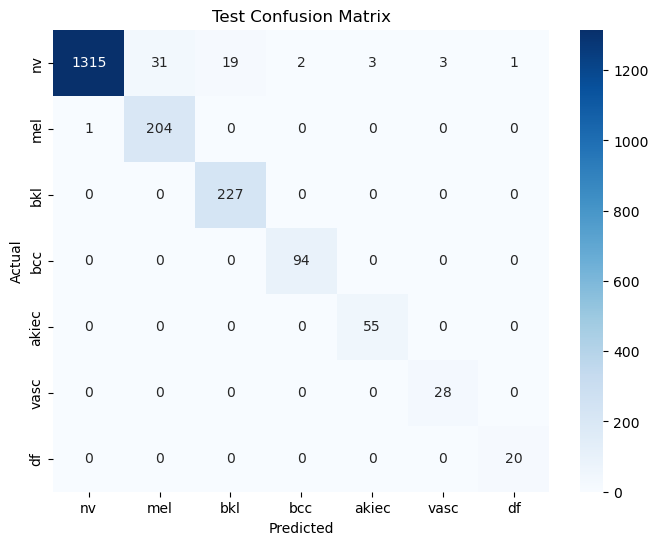

1/1 [==============================] - 0s 14ms/step
Confidence: 1.00
1/1 [==============================] - 0s 14ms/step
Confidence: 0.87
1/1 [==============================] - 0s 16ms/step
Confidence: 0.99
1/1 [==============================] - 0s 18ms/step
Confidence: 0.91
1/1 [==============================] - 0s 15ms/step
Confidence: 1.00
1/1 [==============================] - 0s 17ms/step
Confidence: 0.90
1/1 [==============================] - 0s 16ms/step
Confidence: 1.00
1/1 [==============================] - 0s 17ms/step
Confidence: 1.00
1/1 [==============================] - 0s 16ms/step
Confidence: 0.96
1/1 [==============================] - 0s 15ms/step
Confidence: 1.00
1/1 [==============================] - 0s 17ms/step
Confidence: 0.99
1/1 [==============================] - 0s 20ms/step
Confidence: 0.96
1/1 [==============================] - 0s 18ms/step
Confidence: 1.00
1/1 [==============================] - 0s 15ms/step
Confidence: 0.99
1/1 [=============================

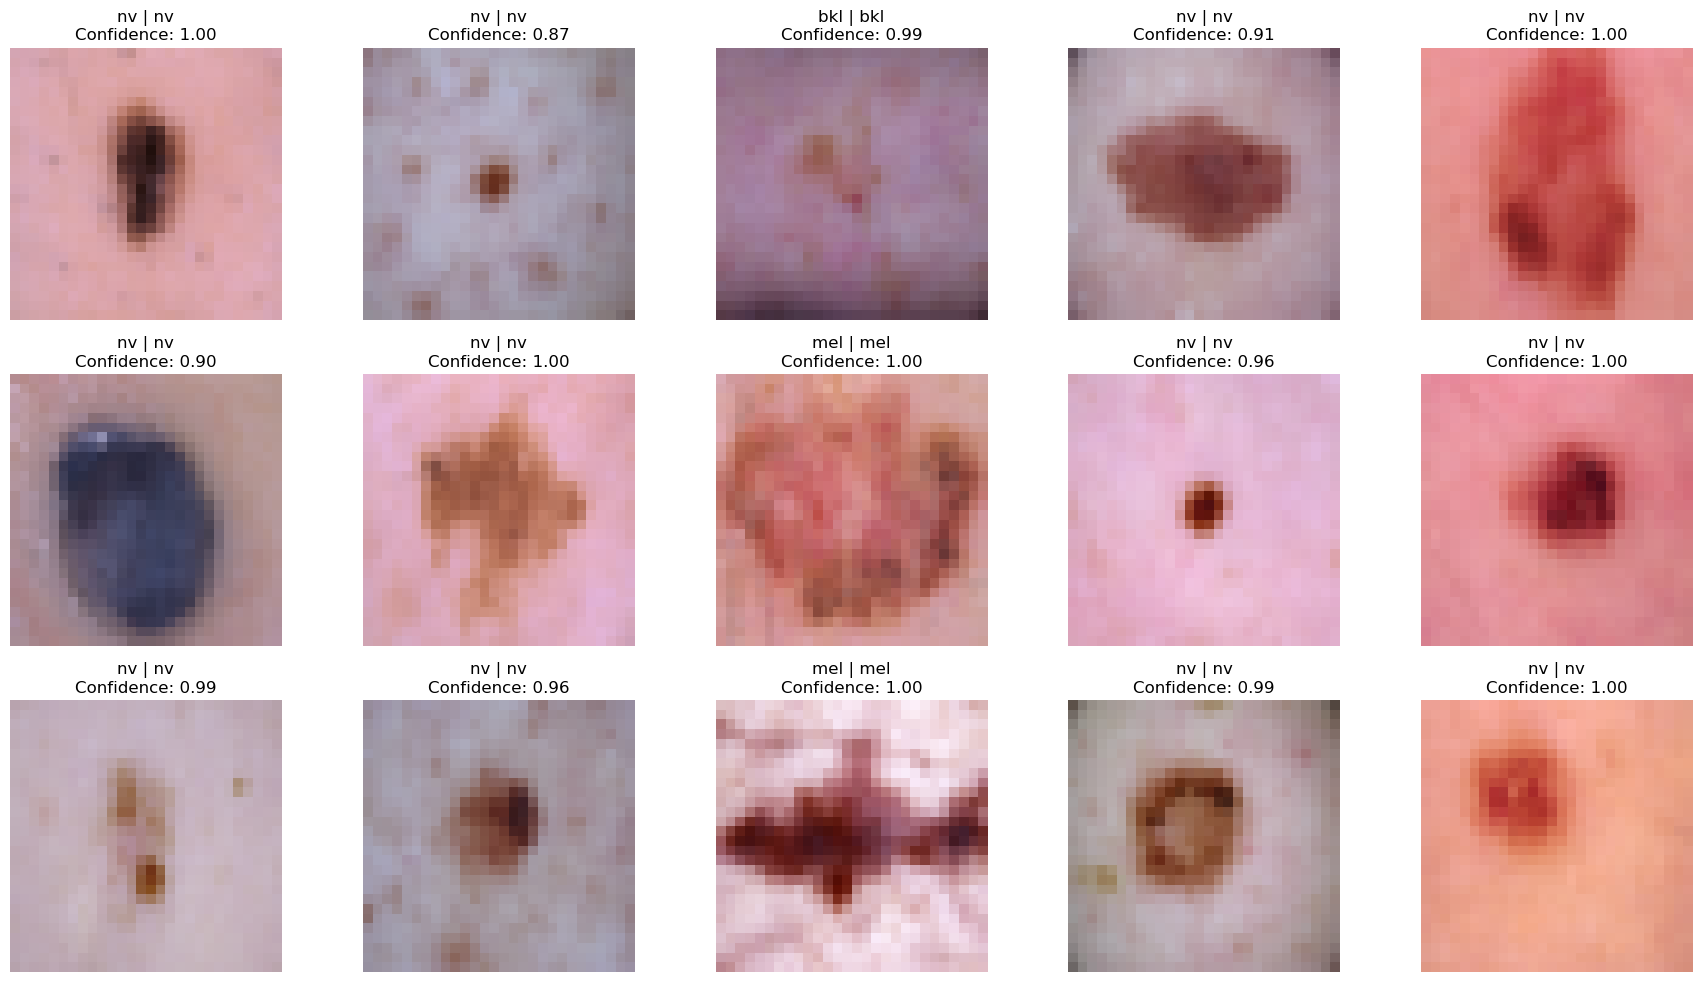

1/1 [==============================] - 0s 14ms/step
Index of max value: 6


In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join("Skin Cancer MNIST HAM10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

data = pd.read_csv(os.path.join("Skin Cancer MNIST HAM10000/",'HAM10000_metadata.csv'))

data['age'].fillna(value=int(data['age'].mean()), inplace=True)
data['age'] = data['age'].astype('int32')

data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    
final_data = pd.concat(frames)

X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

model =create_model()

X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

model2_history = train_model(model, X_train_aug, Y_train_aug, 20)

plot_model_training_curve(model2_history)

test_model(model, X_train_aug, Y_train_aug, X_test_orig, Y_test_orig, label_mapping)

##########################################################################################
image_path ='/home/mostafatarek/Desktop/000my/study/000/Skin/HAM10000/Skin Cancer MNIST HAM10000/HAM10000_images_part_1/ISIC_0029297.jpg' 
img = np.asarray(Image.open(image_path).resize((28,28)))
new_one = img.reshape((1,28,28,3))
v = model.predict(new_one)
max_index = np.argmax(v)

print("Index of max value:", max_index)

<Figure size 1000x500 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Diagnosis Class')

Text(0, 0.5, 'Number of Samples')

Text(0.5, 1.0, 'Distribution of Diagnosis Classes')

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'nv'),
  Text(1, 0, 'mel'),
  Text(2, 0, 'bkl'),
  Text(3, 0, 'bcc'),
  Text(4, 0, 'akiec'),
  Text(5, 0, 'vasc'),
  Text(6, 0, 'df')])

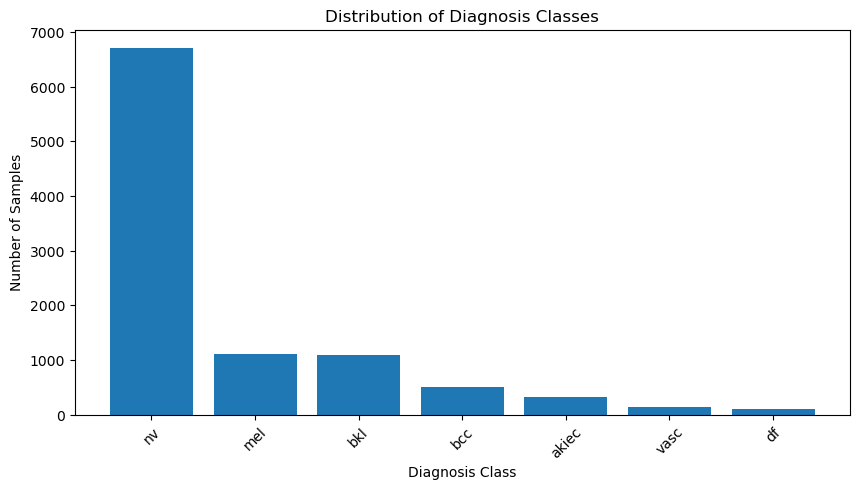

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [12]:
class_counts = data['dx'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Diagnosis Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diagnosis Classes')
plt.xticks(rotation=45)
plt.show()

print(class_counts)


<Figure size 1000x500 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Diagnosis Class')

Text(0, 0.5, 'Number of Samples')

Text(0.5, 1.0, 'Distribution of Diagnosis Classes')

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'nv'),
  Text(1, 0, 'bcc'),
  Text(2, 0, 'mel'),
  Text(3, 0, 'vasc'),
  Text(4, 0, 'bkl'),
  Text(5, 0, 'akiec'),
  Text(6, 0, 'df')])

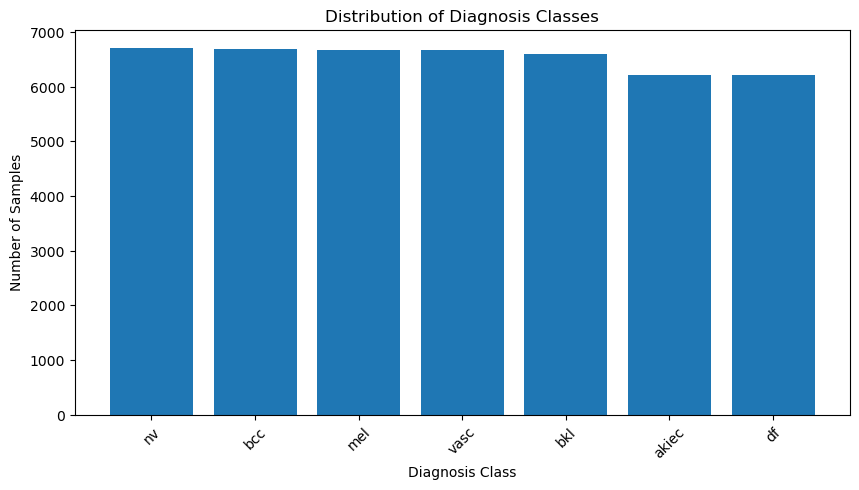

nv       6705
bcc      6682
mel      6678
vasc     6674
bkl      6594
akiec    6213
df       6210
Name: dx, dtype: int64


In [23]:
class_counts = final_data['dx'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Diagnosis Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diagnosis Classes')
plt.xticks(rotation=45)
plt.show()

print(class_counts)


1/1 [==============================] - 0s 51ms/step


Text(0.5, 1.0, 'Predicted: Dermatofibroma (df) \n Confidence: 1.00')

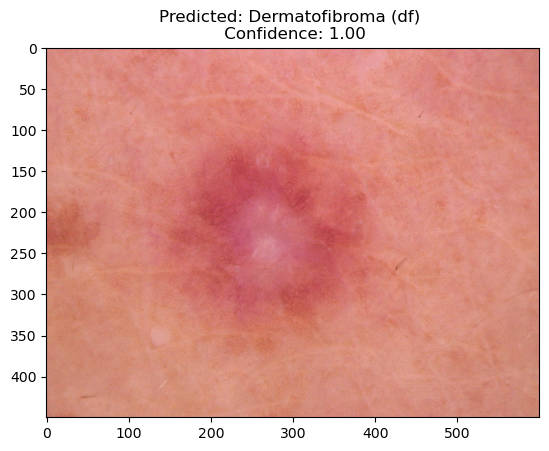

In [5]:
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

    return model;


lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())



model =create_model()


# model2_history = train_model(model, X_train_aug, Y_train_aug, 20)

model.load_weights('/home/mostafatarek/Downloads/model_weights (2).h5')

# plot_model_training_curve(model2_history)


##########################################################################################
image_path = '/home/mostafatarek/Desktop/000my/study/000/Skin/HAM10000/Skin Cancer MNIST HAM10000/HAM10000_images_part_1/ISIC_0029297.jpg'
imgg = np.asarray(Image.open(image_path))

img = np.asarray(Image.open(image_path).resize((28, 28)))
new_one = img.reshape((1, 28, 28, 3))

predictions = model.predict(new_one)
max_index = np.argmax(predictions)
predicted_label = label_mapping[max_index]
confidence = predictions[0, max_index]

plt.imshow(imgg)
plt.title(f'Predicted: {lesion_type_dict[predicted_label]} \n Confidence: {confidence:.2f}')
plt.show()

index                                                        2335
lesion_id                                             HAM_0002218
image_id                                             ISIC_0029448
dx                                                           vasc
dx_type                                                     histo
age                                                             5
sex                                                          male
localization                                                 back
cell_type                                 Vascular lesions (vasc)
path            Skin Cancer MNIST HAM10000/ham10000_images_par...
image_pixel     [[[214, 193, 218], [214, 195, 217], [217, 198,...
label                                                           5
Name: 9795, dtype: object
1/1 [==============================] - 0s 11ms/step


Text(0.5, 1.0, 'Predicted: Vascular lesions (vasc) \n True label: vasc \n Confidence: 1.00')

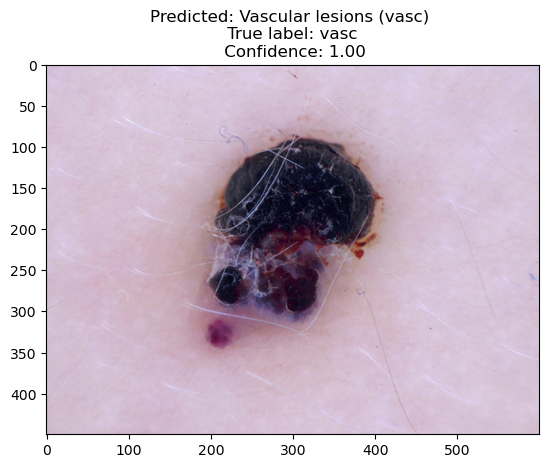

In [37]:
lol = 9795
print(data.iloc[lol])
image_path = data['path'][lol]

imgg = np.asarray(Image.open(image_path))

img = np.asarray(Image.open(image_path).resize((28, 28)))
new_one = img.reshape((1, 28, 28, 3))

predictions = model.predict(new_one)
max_index = np.argmax(predictions)
predicted_label = label_mapping[max_index]
confidence = predictions[0, max_index]

plt.imshow(imgg)
plt.title(f'Predicted: {lesion_type_dict[predicted_label]} \n True label: {data["dx"][lol]} \n Confidence: {confidence:.2f}')
plt.show()